<a href="https://colab.research.google.com/github/aryann25-cmd/BA820-Childcare-Programming-Analysis/blob/main/M2_YashaswiniReddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BA820 Project Proposal: Exploratory Data Analysis

**Course:** BA820 - Unsupervised and Unstructured Machine Learning  
 **Author:** Yashaswini Reddy Vari

**GitHub Repository:** https://github.com/aryann25-cmd/BA820-Childcare-Programming-Analysis

---

## Executive Summary

This project analyzes U.S. county-level childcare costs from 2008 to 2018 using a question-driven exploratory approach. An initial focus on recession-period cost changes revealed substantial overlap across counties and highly imbalanced clusters, suggesting that short-term shocks alone do not meaningfully distinguish underlying cost dynamics.

Based on this finding, the analysis was shifted toward long-run childcare cost trajectories. By constructing features capturing average cost levels, volatility, cumulative growth, and overall trends, clear heterogeneity in how childcare costs evolved across counties was identified .
Clustering results, supported by PCA and hierarchical clustering, indicate that long-term trajectories—not short-term disruptions—drive meaningful differences in county-level childcare costs.

##  Table of Contents

###  Childcare Costs Dataset (Primary)
1. Dataset Overview & Research Motivation
2. Temporal Patterns → *Supports Trajectory Clustering Question*
3. Geographic Heterogeneity → *Supports Market Archetype Question*
4. Affordability Paradox → *Supports Burden-Based Clustering Question*
5. Multivariate Relationships → *Supports Dimensionality Reduction*
6. Summary: Research Questions Validated



###  Synthesis
10. Key Findings Across Both Datasets
11. Conclusion

**Note:** Each analysis directly supports a specific research question from our proposal.

---
# PART I: CHILDCARE COSTS DATASET

## 1. Dataset Overview & Research Motivation

###  Dataset: National Database of Childcare Prices

**Source:** U.S. Department of Labor Women's Bureau (via TidyTuesday)  
**URL:** https://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-05-09

| Characteristic | Details |
|---------------|---------|
| **Observations** | 34,567 county-year combinations |
| **Variables** | 61 features (costs, income, labor, demographics, households) |
| **Temporal** | 2008-2018 (Great Recession → Recovery) |
| **Geographic** | U.S. counties (FIPS coded) |

### Why This Dataset?
**1. Meaningful, Data-Driven Problem:**
- Childcare costs consume 10-20% of household income, creating workforce barriers
- Policy-relevant: Informs subsidy programs and economic development

**2. Enables Insightful Business/Domain Questions:**
- Do counties cluster by cost-affordability-participation *relationships* (not just absolute values)?
- Can we identify trajectory groups showing different recession responses?
- Are there "childcare deserts" with anomalous cost-context patterns?

**3. Suitable for Unsupervised Learning:**
- High dimensionality (61 variables) → dimensionality reduction
- Temporal structure → trajectory clustering
- Complex correlations → natural groupings likely exist
- No obvious labels → unsupervised methods appropriate

**4. Stakeholder Impact:**
- Policymakers: Design targeted interventions
- Employers: Evaluate family benefit programs
- Urban planners: Address infrastructure gaps

### 🔍 Key Variables

**Costs:** `mcsa` (school-age), `mc_infant`, `mc_toddler`, `mc_preschool`  
**Economic:** `mhi_2018` (income), `unr_20to64` (unemployment)  
**Labor:** `flfpr_20to64` (female participation), `h_under6_both_work` (dual-income families)  
**Demographics:** Racial composition, household structures

In [1]:
# Install packages
!pip install -q seaborn>=0.12.0 scikit-learn>=1.2.0

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print(" Setup complete - libraries imported and configured")

 Setup complete - libraries imported and configured


In [2]:
# Load Childcare Costs dataset
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-05-09/childcare_costs.csv"
df_childcare = pd.read_csv(url)

# data overview
print("CHILDCARE COSTS DATASET - STRUCTURE")
print(f"Shape: {df_childcare.shape[0]:,} rows × {df_childcare.shape[1]} columns")
print(f"Time range: {df_childcare['study_year'].min()}-{df_childcare['study_year'].max()}")
print(f"Counties: {df_childcare['county_fips_code'].nunique():,}")
print(f"Missing values: {df_childcare.isnull().sum().sum():,} total")
print(f"\nKey variables present: mcsa ✓, mhi_2018 ✓, flfpr_20to64 ✓")

# Display sample
print("\n Sample Data (first 3 rows):")
df_childcare[['study_year', 'county_fips_code', 'mcsa', 'mhi_2018', 'flfpr_20to64']].head(3)

CHILDCARE COSTS DATASET - STRUCTURE
Shape: 34,567 rows × 61 columns
Time range: 2008-2018
Counties: 3,144
Missing values: 88,636 total

Key variables present: mcsa ✓, mhi_2018 ✓, flfpr_20to64 ✓

 Sample Data (first 3 rows):


,study_year,county_fips_code,mcsa,mhi_2018,flfpr_20to64
0,2008,1001,80.92,58462.55,68.9
1,2009,1001,83.42,60211.71,70.8
2,2010,1001,85.92,61775.80,71.3


In [3]:
# Finding dataset summary: columns, data types, and missingness
def dataset_summary(df, name):
    print(f"\n===== {name} =====")
    print()
    df.info()
    print()
    display(df.describe(include="all"))

# Analyze childcare dataset
dataset_summary(df_childcare, "Childcare Costs Dataset")


===== Childcare Costs Dataset =====

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   county_fips_code           34567 non-null  int64  
 1   study_year                 34567 non-null  int64  
 2   unr_16                     34567 non-null  float64
 3   funr_16                    34567 non-null  float64
 4   munr_16                    34567 non-null  float64
 5   unr_20to64                 34567 non-null  float64
 6   funr_20to64                34567 non-null  float64
 7   munr_20to64                34567 non-null  float64
 8   flfpr_20to64               34567 non-null  float64
 9   flfpr_20to64_under6        34567 non-null  float64
 10  flfpr_20to64_6to17         34567 non-null  float64
 11  flfpr_20to64_under6_6to17  34567 non-null  float64
 12  mlfpr_20to64               34567 non-null  float64
 13  pr_f    

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,...,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool
count,34567.000000,34567.000000,34567.000000,34567.00000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,...,34567.000000,34567.000000,23593.000000,23383.000000,23593.000000,23593.000000,23593.000000,23383.000000,23383.000000,23383.000000
mean,30388.132786,2012.999711,7.465902,7.02902,7.860291,6.900073,6.482007,7.275457,70.086125,68.821409,...,23.456238,7.634403,101.234253,92.523582,146.051770,130.482768,122.232852,113.421657,106.759749,104.189510
std,15161.015383,3.162232,3.538619,3.56342,4.037657,3.446199,3.477956,3.990758,7.696499,11.758088,...,7.956927,4.501044,34.552888,27.669904,53.698566,43.775370,38.538323,32.819372,29.982431,28.961701
min,1001.000000,2008.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,33.600000,0.000000,...,0.000000,0.000000,18.980000,22.000000,27.730000,21.540000,21.540000,43.080000,43.080000,40.030000
25%,18177.000000,2010.000000,5.100000,4.64000,5.200000,4.600000,4.200000,4.700000,65.100000,62.600000,...,17.610000,4.410000,78.650000,75.000000,108.750000,100.000000,95.880000,90.000000,85.085000,84.255000
50%,29177.000000,2013.000000,7.050000,6.59000,7.390000,6.500000,6.000000,6.800000,70.600000,69.600000,...,23.400000,6.630000,96.530000,88.180000,134.500000,120.990000,113.990000,106.000000,100.250000,99.650000
75%,45081.000000,2016.000000,9.350000,8.88000,9.920000,8.700000,8.250000,9.200000,75.500000,76.100000,...,28.930000,9.920000,119.380000,107.500000,166.330000,148.710000,139.300000,129.315000,124.950000,120.200000
max,56045.000000,2018.000000,36.110000,38.24000,39.740000,33.900000,44.500000,45.500000,100.000000,100.000000,...,87.500000,66.480000,375.400000,308.000000,470.000000,419.000000,385.000000,430.940000,376.320000,331.340000


## 2. Temporal Patterns → Trajectory Clustering Question

**Research Question:**  
*"Can we identify distinct groups of counties that experienced fundamentally different childcare cost dynamics from 2008-2018?"*

**Why This Analysis Matters:**
- Understanding trajectory types helps predict which counties face accelerating crises
- Different trajectories may require different policy interventions
- **Surprising outcome to look for:** Counties with similar 2008 costs diverging dramatically by 2018

TEMPORAL TRENDS: 2008-2018
            count    mean  median    std
study_year                              
2008         1424   89.70   85.10  30.30
2009         1901   91.84   87.00  29.78
2010         1991   92.01   87.17  31.11
2011         1992   94.35   88.34  32.56
2012         2053   97.20   90.50  33.01
2013         2074  101.58   97.82  33.08
2014         2323  103.95   99.09  34.05
2015         2398  107.24  100.00  36.27
2016         2641  105.40  100.00  32.92
2017         2436  107.56  102.27  34.49
2018         2360  112.59  106.22  40.26

📈 Average annual growth: 2.31%
   Range: -1.72% to 4.68%
   During recession (2009): 2.39%


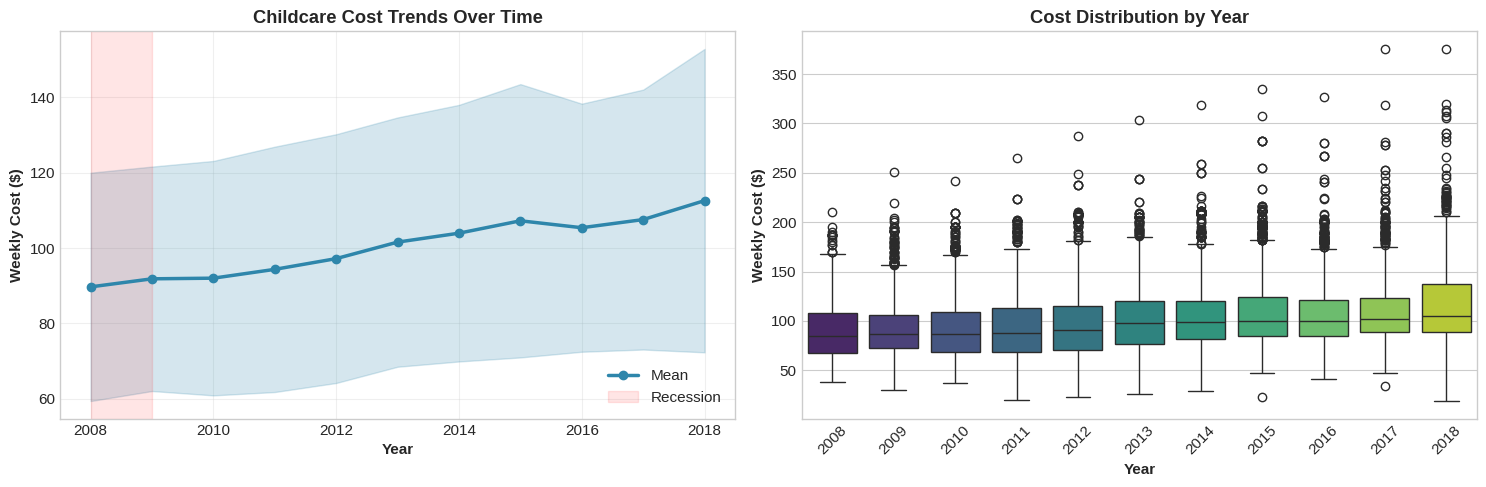

In [4]:
# Temporal analysis
temporal_stats = df_childcare.groupby('study_year')['mcsa'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)

print("TEMPORAL TRENDS: 2008-2018")
print(temporal_stats)

# Year-over-year growth
yearly_change = temporal_stats['mean'].pct_change() * 100
print(f"\n📈 Average annual growth: {yearly_change.mean():.2f}%")
print(f"   Range: {yearly_change.min():.2f}% to {yearly_change.max():.2f}%")
print(f"   During recession (2009): {yearly_change.loc[2009]:.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Trend with uncertainty
axes[0].plot(temporal_stats.index, temporal_stats['mean'],
            marker='o', linewidth=2.5, color='#2E86AB', label='Mean')
axes[0].fill_between(temporal_stats.index,
                    temporal_stats['mean'] - temporal_stats['std'],
                    temporal_stats['mean'] + temporal_stats['std'],
                    alpha=0.2, color='#2E86AB')
axes[0].axvspan(2008, 2009, alpha=0.1, color='red', label='Recession')
axes[0].set_xlabel('Year', fontweight='bold')
axes[0].set_ylabel('Weekly Cost ($)', fontweight='bold')
axes[0].set_title('Childcare Cost Trends Over Time', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution by year
df_sample = df_childcare[df_childcare['mcsa'].notna()].groupby('study_year', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 2000), random_state=42)
)
sns.boxplot(data=df_sample, x='study_year', y='mcsa', ax=axes[1], palette='viridis')
axes[1].set_xlabel('Year', fontweight='bold')
axes[1].set_ylabel('Weekly Cost ($)', fontweight='bold')
axes[1].set_title('Cost Distribution by Year', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


From the childcare cost trends, we find that the mean weekly cost increase steadily from 2008 to 2018. There is no sharp break during the recession period as the costs continue rising. Based on these, childcare costs did not fall even during recession, and the widening band implies that counties are not moving on the same pace which means some counties esperienced much faster cost growth while others slower.

From the boxplots, we can see that The median cost increases almost every year. The upper tail outlines become more extreme after 2013. The boxplots show that high-cost counties pulled away faster, creating more extreme high prices, while lower-cost counties increased more slowly. This means the difference between counties became larger over time.

## 3. Geographic Heterogeneity → Market Archetype Question

**Research Question:**  
*"Do distinct 'childcare market archetypes' exist where counties cluster by RELATIONSHIPS between cost, affordability, and labor participation (not absolute values)?"*

**Why This Analysis Matters:**
- High geographic variation suggests natural groupings exist
- Understanding archetypes enables targeted policy design
- **Surprising outcome to look for:** Counties grouping by dynamics rather than geography

GEOGRAPHIC HETEROGENEITY
Counties analyzed: 3,144
Cost range: $18.98 - $313.96
Ratio (high/low): 16.54x
Coefficient of variation: 0.335

→ High CV indicates SUBSTANTIAL heterogeneity - clustering opportunity!


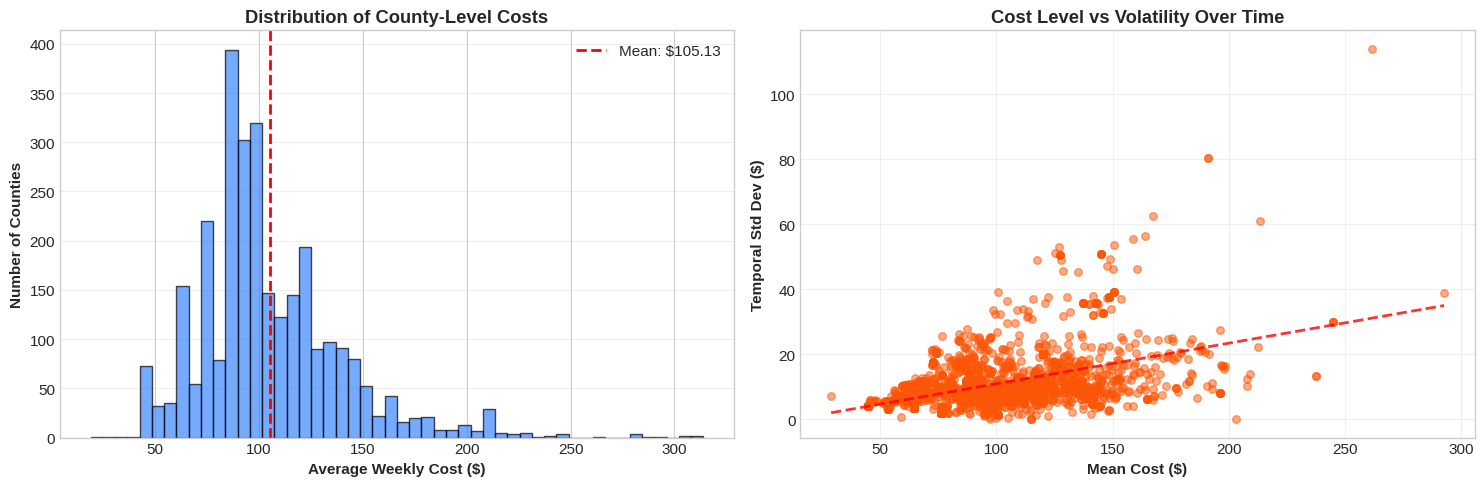

In [5]:
# Geographic variation analysis
county_stats = df_childcare.groupby('county_fips_code')['mcsa'].agg([
    'count', 'mean', 'std'
]).round(2)


print("GEOGRAPHIC HETEROGENEITY")
print(f"Counties analyzed: {len(county_stats):,}")
print(f"Cost range: ${county_stats['mean'].min():.2f} - ${county_stats['mean'].max():.2f}")
print(f"Ratio (high/low): {county_stats['mean'].max() / county_stats['mean'].min():.2f}x")
print(f"Coefficient of variation: {county_stats['mean'].std() / county_stats['mean'].mean():.3f}")
print(f"\n→ High CV indicates SUBSTANTIAL heterogeneity - clustering opportunity!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution
axes[0].hist(county_stats['mean'], bins=50, edgecolor='black', alpha=0.7, color='#3A86FF')
axes[0].axvline(county_stats['mean'].mean(), color='red', linestyle='--',
               linewidth=2, label=f"Mean: ${county_stats['mean'].mean():.2f}")
axes[0].set_xlabel('Average Weekly Cost ($)', fontweight='bold')
axes[0].set_ylabel('Number of Counties', fontweight='bold')
axes[0].set_title('Distribution of County-Level Costs', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Mean vs volatility -
county_clean = county_stats[['mean', 'std']].dropna()
axes[1].scatter(county_clean['mean'], county_clean['std'], alpha=0.5, s=30, color='#FB5607')

# Fit regression line
z = np.polyfit(county_clean['mean'], county_clean['std'], 1)
p = np.poly1d(z)
x_line = np.linspace(county_clean['mean'].min(), county_clean['mean'].max(), 100)
axes[1].plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8)

axes[1].set_xlabel('Mean Cost ($)', fontweight='bold')
axes[1].set_ylabel('Temporal Std Dev ($)', fontweight='bold')
axes[1].set_title('Cost Level vs Volatility Over Time', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


From the distribution of county-level costs, most of the counties cost around 80 to 130 dollar per week, but there are many counties far above that, stretching past 200 to 300 dollar per week. For the scatter plot, we found that Higher childcare costs often come with more instability, but not always. For instance, two counties might both cost aroung 80 - 120 dollar per week, but one has stable prices, other one has wild sings over time. Put them together, two counties can charge the same price for childcare, but feel completely different to families, and that difference is exactly what defines a childcare market.

## 4. Affordability Paradox → Burden-Based Clustering

**Research Question:**  
*"Can we detect 'childcare deserts' through anomalous cost-context patterns, where burden relative to income reveals different market dynamics?"*

**Why This Analysis Matters:**
- Absolute costs don't tell the full story - relative burden matters
- Understanding cost-income relationships reveals equity issues
- **Surprising outcome to look for:** High-income counties with low participation despite "affordable" costs

AFFORDABILITY ANALYSIS
Mean burden: 10.65%
Median burden: 10.50%
Exceeding 10% threshold: 56.0%


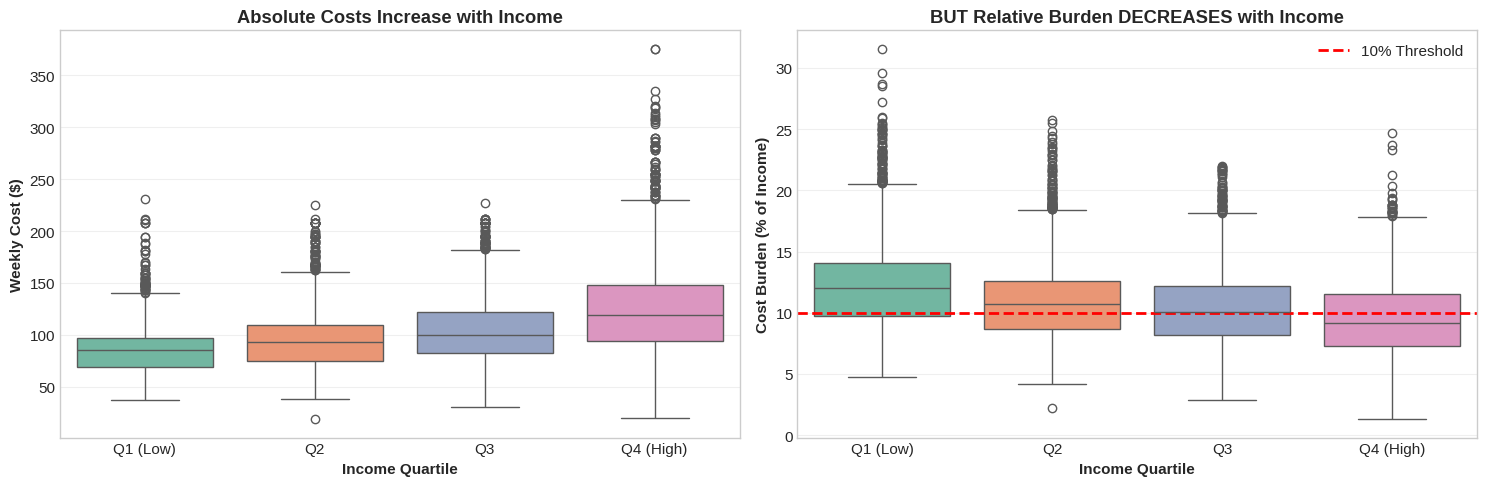

In [6]:
# Affordability analysis
df_afford = df_childcare[
    df_childcare['mcsa'].notna() &
    df_childcare['mhi_2018'].notna()
].copy()

df_afford['weekly_income'] = df_afford['mhi_2018'] / 52
df_afford['cost_burden_pct'] = (df_afford['mcsa'] / df_afford['weekly_income']) * 100
df_afford = df_afford[df_afford['cost_burden_pct'] <= 50]  # Remove outliers


print("AFFORDABILITY ANALYSIS")

print(f"Mean burden: {df_afford['cost_burden_pct'].mean():.2f}%")
print(f"Median burden: {df_afford['cost_burden_pct'].median():.2f}%")
print(f"Exceeding 10% threshold: {(df_afford['cost_burden_pct'] > 10).mean()*100:.1f}%")

# Income quartile analysis
df_afford['income_quartile'] = pd.qcut(df_afford['mhi_2018'], q=4,
                                       labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

# Visualize THE PARADOX
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Absolute costs by income
sns.boxplot(data=df_afford, x='income_quartile', y='mcsa', ax=axes[0], palette='Set2')
axes[0].set_xlabel('Income Quartile', fontweight='bold')
axes[0].set_ylabel('Weekly Cost ($)', fontweight='bold')
axes[0].set_title('Absolute Costs Increase with Income', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# RELATIVE burden by income
sns.boxplot(data=df_afford, x='income_quartile', y='cost_burden_pct', ax=axes[1], palette='Set2')
axes[1].axhline(10, color='red', linestyle='--', linewidth=2, label='10% Threshold')
axes[1].set_xlabel('Income Quartile', fontweight='bold')
axes[1].set_ylabel('Cost Burden (% of Income)', fontweight='bold')
axes[1].set_title('BUT Relative Burden DECREASES with Income', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


From the first income quartile, we can see that as income go up, the costs go up.High income counties pay more per week for childcare, while low income counties pay less in absolute terms. For the second income quartile, we found that low income counties spend a large share of income on childcare. As income rises, childcare takes up a smaller percenage of household income. The red 10% line shows an benchmark, many low-income conties are above it, and higer income counties are mostly below it. Those give us a picture that some places look affordable but still function like childcare deserts because the burden on families is too high.  

## 5. Multivariate Relationships → Dimensionality Reduction

**Analysis Goal:**  
Understand correlation structure and assess whether dimensionality reduction can reveal latent factors driving childcare markets.


CORRELATION STRUCTURE
               mcsa  mhi_2018  flfpr_20to64  unr_20to64
mcsa          1.000     0.499         0.263      -0.082
mhi_2018      0.499     1.000         0.528      -0.407
flfpr_20to64  0.263     0.528         1.000      -0.420
unr_20to64   -0.082    -0.407        -0.420       1.000

 PCA DIMENSIONALITY REDUCTION:
   Original features: 59
   Components for 90% variance: 16
   Reduction: 72.9%

   PC1: 26.2% | PC2: 16.2%


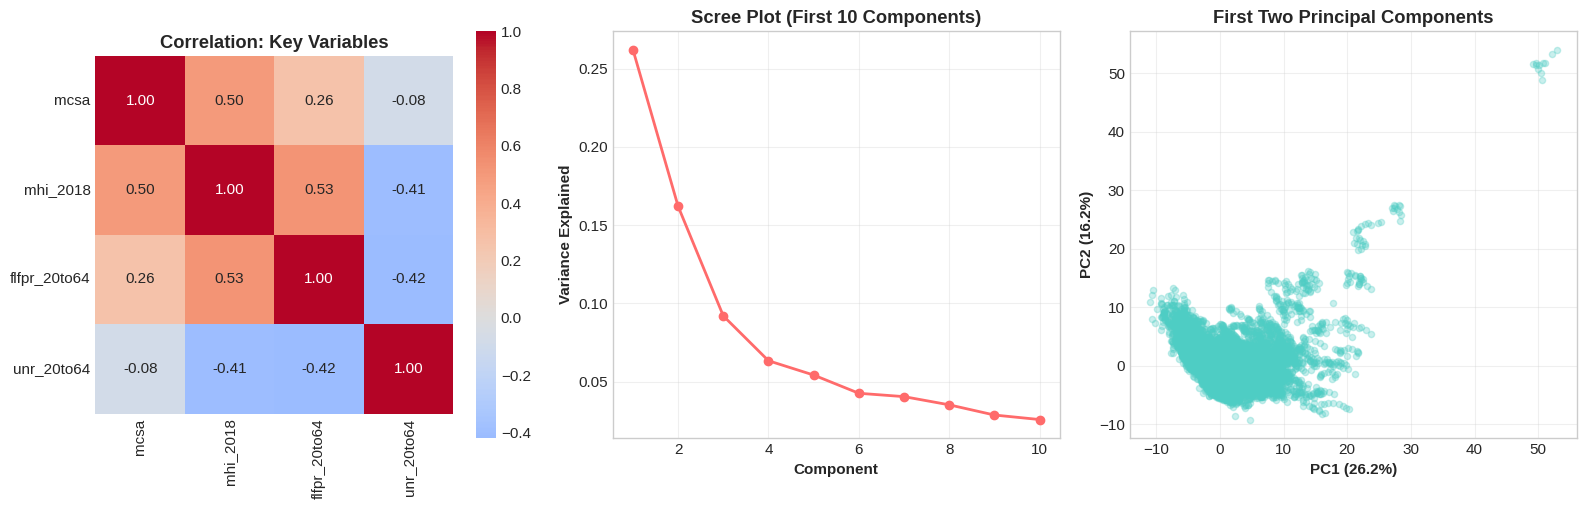

In [7]:
# Correlation analysis
key_vars = ['mcsa', 'mhi_2018', 'flfpr_20to64', 'unr_20to64']
df_corr = df_childcare[key_vars].dropna()
corr_matrix = df_corr.corr()

print("CORRELATION STRUCTURE")

print(corr_matrix.round(3))

# PCA for dimensionality assessment
numeric_cols = df_childcare.select_dtypes(include=[np.number]).columns.tolist()
exclude = ['county_fips_code', 'study_year']
features = [c for c in numeric_cols if c not in exclude]
df_pca = df_childcare[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

var_explained = pca.explained_variance_ratio_
cum_var = np.cumsum(var_explained)
n_90 = np.argmax(cum_var >= 0.90) + 1

print(f"\n PCA DIMENSIONALITY REDUCTION:")
print(f"   Original features: {len(features)}")
print(f"   Components for 90% variance: {n_90}")
print(f"   Reduction: {(1 - n_90/len(features))*100:.1f}%")
print(f"\n   PC1: {var_explained[0]*100:.1f}% | PC2: {var_explained[1]*100:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
           center=0, ax=axes[0], square=True)
axes[0].set_title('Correlation: Key Variables', fontweight='bold')

# Scree plot
axes[1].plot(range(1, 11), var_explained[:10], marker='o', linewidth=2, color='#FF6B6B')
axes[1].set_xlabel('Component', fontweight='bold')
axes[1].set_ylabel('Variance Explained', fontweight='bold')
axes[1].set_title('Scree Plot (First 10 Components)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# PC scatter
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, s=20, color='#4ECDC4')
axes[2].set_xlabel(f'PC1 ({var_explained[0]*100:.1f}%)', fontweight='bold')
axes[2].set_ylabel(f'PC2 ({var_explained[1]*100:.1f}%)', fontweight='bold')
axes[2].set_title('First Two Principal Components', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



From the correlation table, we can see the income (mhi) and childcare cost (mcsa) have a higher correlation of 0.5 which mean richer counties tend to ahve higher childcare prices. For income(mhi) also ahve a higher correlation with female participation (flfpr_20to64), whcih means the higher-income counties tend to have higher labor force participation.On the other side, we found that unemployment (unr) have a lower correlation with income and female labor. Those indicates higher childcare prices usually contribute to berden and volatility, and people have to keep working.

In [8]:
years_per_county = (
    df_childcare
    .groupby("county_fips_code")["study_year"]
    .nunique()
)

years_per_county.describe()


,study_year
count,3144.000000
mean,10.994593
std,0.200943
min,1.000000
25%,11.000000
50%,11.000000
75%,11.000000
max,11.000000


In [9]:
full_coverage = years_per_county[years_per_county == years_per_county.max()]
len(full_coverage), len(years_per_county)


(3140, 3144)

In [10]:
#verifying cost scale consistency
df_childcare.groupby("study_year")["mcsa"].describe()[["mean", "std"]]


,mean,std
study_year,,
2008,89.699487,30.298368
2009,91.838853,29.775359
2010,92.012551,31.107882
2011,94.349347,32.559490
2012,97.203132,33.006000
2013,101.581225,33.081757
2014,103.954068,34.052022
2015,107.236906,36.273923
2016,105.395445,32.923725


#Main Question - do counties cluster based on how childcare costs changed during the 2008–2009 recession and how they recovered afterward

In [11]:
# Identifying counties with full coverage
years_per_county = (
    df_childcare
    .groupby("county_fips_code")["study_year"]
    .nunique()
)

full_years = years_per_county.max()
valid_counties = years_per_county[years_per_county == full_years].index

print("Total counties:", len(years_per_county))
print("Counties with full coverage:", len(valid_counties))
print("Years per county (min / max):",
      years_per_county.min(), "/", years_per_county.max())

df_full = df_childcare[df_childcare["county_fips_code"].isin(valid_counties)].copy()
print("Filtered dataset shape:", df_full.shape)


Total counties: 3144
Counties with full coverage: 3140
Years per county (min / max): 1 / 11
Filtered dataset shape: (34540, 61)


The vast majority of U.S. counties (3140 out of 3144) have complete childcare cost data across the full 2008–2018 period. This near-complete temporal coverage allows counties to be compared using aligned cost trajectories without distortion from missing years, making them suitable for trajectory-based unsupervised analysis.

In [12]:
pivot = df_full.pivot(
    index="county_fips_code",
    columns="study_year",
    values="mcsa"
).sort_index(axis=1)

print("Pivot table shape (counties × years):", pivot.shape)
pivot.head()


Pivot table shape (counties × years): (3140, 11)


study_year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
county_fips_code,,,,,,,,,,,
1001,80.92,83.42,85.92,88.43,90.93,93.43,95.94,95.94,95.94,95.94,95.94
1003,95.77,95.10,94.43,93.77,93.10,92.43,91.76,95.94,100.11,104.28,108.45
1005,69.24,70.91,72.58,74.25,75.91,77.58,79.25,79.25,79.25,79.25,79.25
1007,81.09,83.42,85.76,88.09,90.43,92.77,95.10,96.77,98.44,100.11,101.78
1009,105.30,104.26,103.23,102.20,101.16,100.13,99.09,105.99,112.88,119.78,126.67


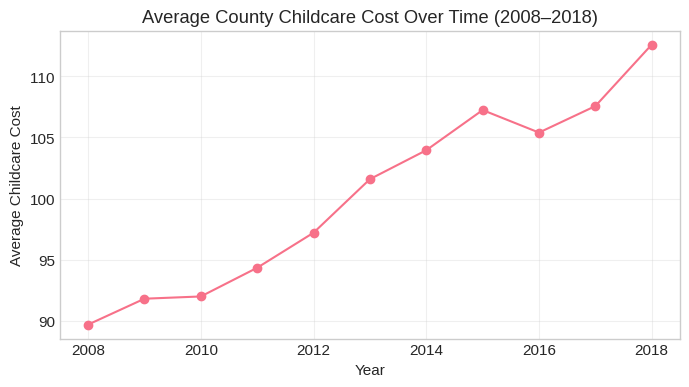

In [39]:
avg_cost_by_year = pivot.mean(axis=0)

plt.figure(figsize=(8,4))
plt.plot(avg_cost_by_year.index, avg_cost_by_year.values, marker="o")
plt.title("Average County Childcare Cost Over Time (2008–2018)")
plt.xlabel("Year")
plt.ylabel("Average Childcare Cost")
plt.grid(alpha=0.3)
plt.show()


While this graph confirms that childcare costs rose nationally during this period, this aggregate view masks potential heterogeneity across counties. Counties may have followed very different cost trajectories despite sharing a similar overall upward trend.

In [13]:
recession_features = pd.DataFrame(index=pivot.index)

recession_features["pct_change_08_09"] = (
    (pivot[2009] - pivot[2008]) / pivot[2008]
)
recession_features["recession_slope"] = pivot[2009] - pivot[2008]
recession_features["recovery_slope"] = pivot[2012] - pivot[2010]
recession_features["dip_then_rebound"] = (
    (pivot[2009] < pivot[2008]) &
    (pivot[2012] > pivot[2009])
).astype(int)

recession_features = recession_features.dropna()


In [14]:
from sklearn.cluster import KMeans
scaler = StandardScaler()
X_recession = scaler.fit_transform(recession_features)

print("Scaled recession feature matrix shape:", X_recession.shape)


Scaled recession feature matrix shape: (1423, 4)


In [15]:
kmeans_recession = KMeans(n_clusters=3, random_state=42)
recession_features["cluster"] = kmeans_recession.fit_predict(X_recession)

print(recession_features["cluster"].value_counts())


cluster
0    1124
2     271
1      28
Name: count, dtype: int64


Recession-period clustering produces highly imbalanced groups, with the majority of counties concentrated in a single cluster and only a small number exhibiting distinct recession or rebound patterns. This suggests that short-window recession dynamics alone are insufficient to capture persistent structural differences in childcare cost behavior across counties.

#Recession & recovery features

In [16]:
recession_features = pd.DataFrame(index=pivot.index)

recession_features["pct_change_08_09"] = (
    (pivot[2009] - pivot[2008]) / pivot[2008]
)

recession_features["recession_slope"] = pivot[2009] - pivot[2008]
recession_features["recovery_slope"] = pivot[2012] - pivot[2010]

recession_features["dip_then_rebound"] = (
    (pivot[2009] < pivot[2008]) &
    (pivot[2012] > pivot[2009])
).astype(int)

recession_features = recession_features.dropna()

print("Recession feature matrix shape:", recession_features.shape)
recession_features.head()


Recession feature matrix shape: (1423, 4)


,pct_change_08_09,recession_slope,recovery_slope,dip_then_rebound
county_fips_code,,,,
1001,0.030895,2.50,5.01,0
1003,-0.006996,-0.67,-1.33,0
1005,0.024119,1.67,3.33,0
1007,0.028734,2.33,4.67,0
1009,-0.009877,-1.04,-2.07,0


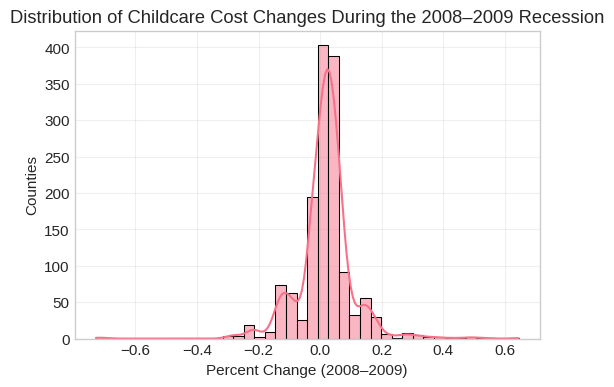

In [40]:
plt.figure(figsize=(6,4))
sns.histplot(recession_features["pct_change_08_09"], bins=40, kde=True)
plt.title("Distribution of Childcare Cost Changes During the 2008–2009 Recession")
plt.xlabel("Percent Change (2008–2009)")
plt.ylabel("Counties")
plt.grid(alpha=0.3)
plt.show()


The histogram shows that most counties experienced relatively small changes clustered around zero, indicating that childcare costs were fairly rigid during the recession. However, the presence of long tails on both sides suggests meaningful heterogeneity, with some counties experiencing sharp cost declines and others seeing notable increases despite the broader economic downturn.

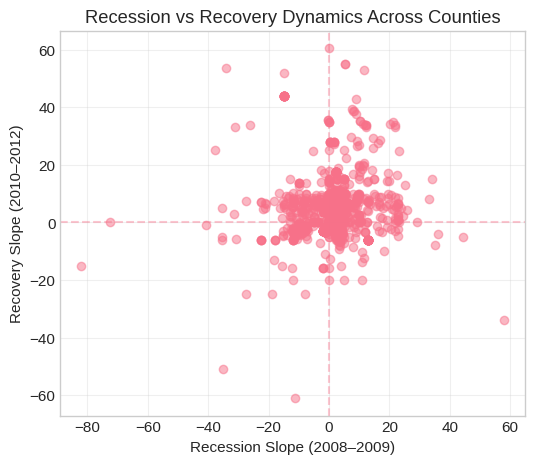

In [41]:
plt.figure(figsize=(6,5))
plt.scatter(
    recession_features["recession_slope"],
    recession_features["recovery_slope"],
    alpha=0.5
)
plt.axhline(0, linestyle="--", alpha=0.4)
plt.axvline(0, linestyle="--", alpha=0.4)
plt.xlabel("Recession Slope (2008–2009)")
plt.ylabel("Recovery Slope (2010–2012)")
plt.title("Recession vs Recovery Dynamics Across Counties")
plt.grid(alpha=0.3)
plt.show()


To understand how counties recovered after the recession, I compared recession-period cost changes with subsequent recovery trends. The scatter plot shows substantial dispersion across counties rather than a single dominant pattern. While many counties cluster near the origin, indicating modest recession impacts and recoveries, there are clear outliers that experienced sharp declines followed by strong rebounds, as well as counties that continued to struggle post-recession. This lack of a uniform recession–recovery relationship suggests that short-term economic shocks alone do not fully explain long-run childcare cost dynamics.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_recession = scaler.fit_transform(recession_features)

print("Scaled recession feature matrix shape:", X_recession.shape)


Scaled recession feature matrix shape: (1423, 4)


In [18]:
from sklearn.cluster import KMeans

kmeans_recession = KMeans(n_clusters=3, random_state=42)
recession_features["cluster"] = kmeans_recession.fit_predict(X_recession)

print("Recession-based cluster counts:")
print(recession_features["cluster"].value_counts())


Recession-based cluster counts:
cluster
0    1124
2     271
1      28
Name: count, dtype: int64


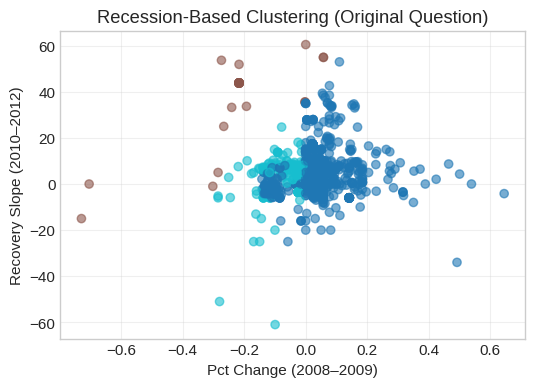

In [19]:
plt.figure(figsize=(6, 4))
plt.scatter(
    recession_features["pct_change_08_09"],
    recession_features["recovery_slope"],
    c=recession_features["cluster"],
    cmap="tab10",
    alpha=0.6
)
plt.xlabel("Pct Change (2008–2009)")
plt.ylabel("Recovery Slope (2010–2012)")
plt.title("Recession-Based Clustering (Original Question)")
plt.grid(True, alpha=0.3)
plt.show()


The recession-based clustering shows substantial overlap between clusters, with most counties concentrated near the center of the feature space and only a small number of extreme outliers forming separate groups. Cluster sizes are highly imbalanced, suggesting that short-term recession and recovery dynamics do not meaningfully differentiate most counties. This indicates that recession-period behavior alone is insufficient to capture persistent structural differences in childcare cost dynamics, motivating a shift toward analyzing longer-run cost trajectories.

#REFINED QUESTION - Do county-level childcare costs between 2008 and 2018 follow heterogeneous trajectories over time, characterized by differences in growth, volatility, and recession response, even among counties with similar baseline cost levels?

The initial analysis focused on whether counties could be meaningfully differentiated based on their short-term childcare cost responses during the Great Recession and subsequent recovery period. However, exploratory clustering based on recession-era features revealed substantial overlap across counties, with only a small number of extreme outliers forming distinct groups. Cluster sizes were highly imbalanced, and most counties remained concentrated near the center of the feature space, suggesting that short-term recession dynamics do not capture persistent structural differences in childcare cost behavior.

These findings motivated a refinement of the research question toward examining longer-run cost trajectories. By shifting focus to multi-year growth, volatility, and overall trend patterns between 2008 and 2018, the analysis aims to identify whether counties with similar baseline costs nevertheless follow heterogeneous long-term childcare cost paths.

In [20]:
trajectory_features = pd.DataFrame(index=pivot.index)

trajectory_features["mean_cost"] = pivot.mean(axis=1)
trajectory_features["volatility"] = pivot.std(axis=1)

trajectory_features["growth_08_18"] = (
    (pivot[2018] - pivot[2008]) / pivot[2008]
)

trajectory_features["trend_slope"] = pivot[2018] - pivot[2008]

trajectory_features = trajectory_features.dropna()

print("Trajectory feature matrix shape:", trajectory_features.shape)
trajectory_features.head()


Trajectory feature matrix shape: (1274, 4)


,mean_cost,volatility,growth_08_18,trend_slope
county_fips_code,,,,
1001,91.159091,5.649102,0.185615,15.02
1003,96.830909,5.294292,0.132401,12.68
1005,76.065455,3.763436,0.144570,10.01
1007,92.160000,6.963501,0.255149,20.69
1009,107.335455,8.809739,0.202944,21.37


In [21]:
scaler = StandardScaler()
X_traj = scaler.fit_transform(trajectory_features)

print("Scaled trajectory feature matrix shape:", X_traj.shape)


Scaled trajectory feature matrix shape: (1274, 4)


Because the trajectory features are measured on different scales , we standardizes all features to have zero mean and unit variance.
This is to make sure that clusters reflect structural differences, not measurement units.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_traj)

trajectory_features["PC1"] = X_pca[:, 0]
trajectory_features["PC2"] = X_pca[:, 1]

print("Explained variance ratios:", pca.explained_variance_ratio_)


Explained variance ratios: [0.63056038 0.26423681]


I used Principal Component Analysis (PCA) to compress the four trajectory features into two dimensions that capture most of the variation across counties.

The first two principal components explain approximately 89% of the total variance.

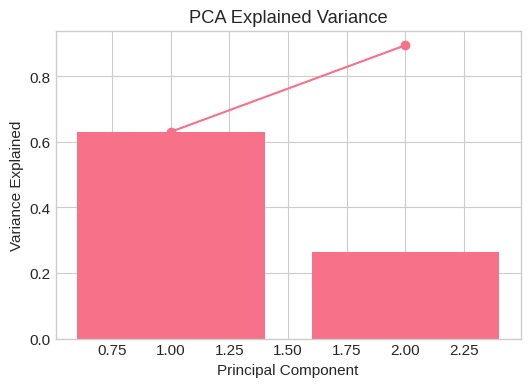

In [42]:
import matplotlib.pyplot as plt
import numpy as np
explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(6,4))
plt.bar(range(1, len(explained_var) + 1), explained_var)
plt.plot(range(1, len(explained_var) + 1),
         np.cumsum(explained_var),
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("PCA Explained Variance")
plt.show()


In [31]:
kmeans_traj = KMeans(n_clusters=2, random_state=42)
trajectory_features["cluster"] = kmeans_traj.fit_predict(X_traj)

print("Trajectory-based cluster counts:")
print(trajectory_features["cluster"].value_counts())


Trajectory-based cluster counts:
cluster
0    995
1    279
Name: count, dtype: int64


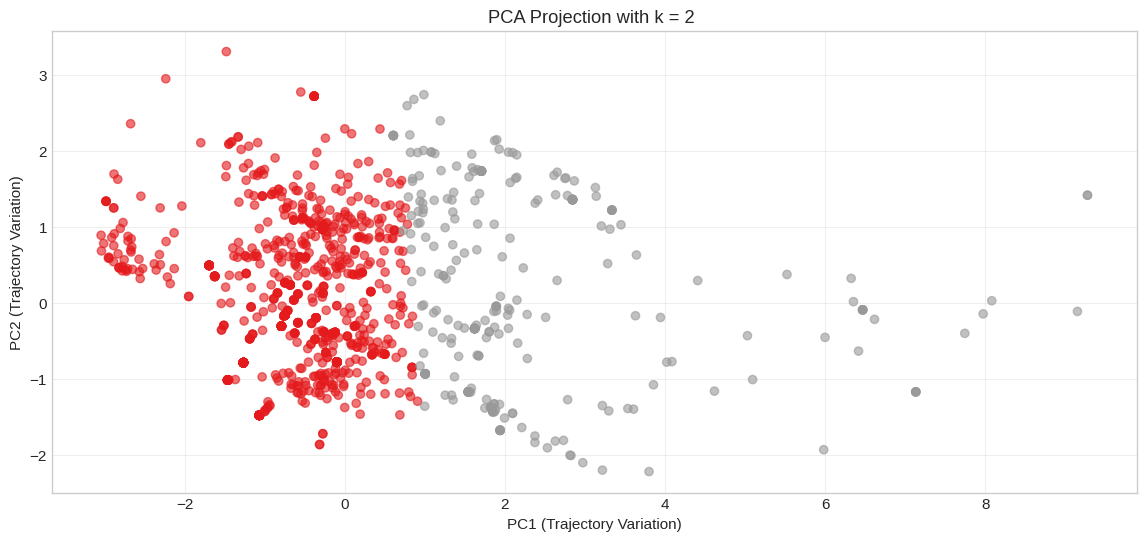

In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_traj)

#  k = 2
kmeans_2 = KMeans(n_clusters=2, random_state=42)
clusters_2 = kmeans_2.fit_predict(X_traj)

plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters_2,
    cmap="Set1",
    alpha=0.6
)
plt.xlabel("PC1 (Trajectory Variation)")
plt.ylabel("PC2 (Trajectory Variation)")
plt.title("PCA Projection with k = 2 ")
plt.grid(True, alpha=0.3)
plt.show()


In [23]:
kmeans_traj = KMeans(n_clusters=4, random_state=42)
trajectory_features["cluster"] = kmeans_traj.fit_predict(X_traj)

print("Trajectory-based cluster counts:")
print(trajectory_features["cluster"].value_counts())


Trajectory-based cluster counts:
cluster
3    576
0    397
1    275
2     26
Name: count, dtype: int64


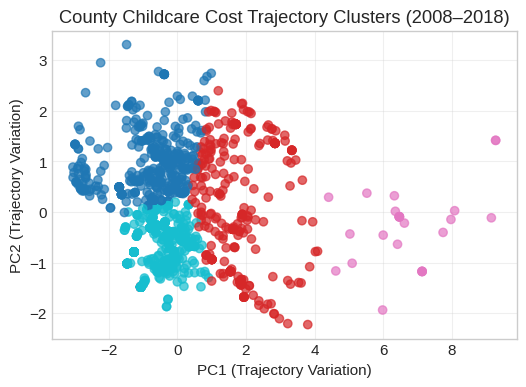

In [24]:
 plt.figure(figsize=(6, 4))
plt.scatter(
    trajectory_features["PC1"],
    trajectory_features["PC2"],
    c=trajectory_features["cluster"],
    cmap="tab10",
    alpha=0.7
)
plt.xlabel("PC1 (Trajectory Variation)")
plt.ylabel("PC2 (Trajectory Variation)")
plt.title("County Childcare Cost Trajectory Clusters (2008–2018)")
plt.grid(True, alpha=0.3)
plt.show()


Cluster 0 – Blue: Low-Growth and Stable Trajectories

Located on the left side of the plot with generally positive PC2 values, represents counties with low overall childcare cost growth and relatively stable trajectories. I found that these counties experienced gradual, predictable increases without major fluctuations. This pattern suggests more stable childcare markets, potentially driven by slower demand growth or stronger cost controls.


Cluster 1 – light blue: Low-Growth but Volatile Trajectories

The light blue cluster, concentrated in the lower-left region of the plot, also shows low long-run growth, negative PC1, but differs from the blue cluster in terms of higher volatility, reflected by lower PC2 values. These counties did not see large cumulative cost increases, but their trajectories were more uneven, indicating short-term instability rather than sustained upward trends.

Cluster 2 – Red: Moderate/High Growth with Diverse Trajectories

The red cluster, which is near the center-right of the plot, represents counties with moderate to high long-run growth in childcare costs. The wide vertical spread along PC2 indicates substantial heterogeneity in trajectory shape, meaning counties in this group reached similar long-term outcomes through different paths. I interpreted this cluster as reflecting counties under rising cost pressure but with varied adjustment dynamics.


Pink: Outliers, Extremely High-Growth

The pink cluster, clearly separated on the far right of PC1, consists of counties with very high childcare cost growth over the period. These counties stand out as outliers with extreme trajectories, often accompanied by volatility. This pattern suggests structurally different childcare markets, potentially driven by rapid population growth, supply constraints, or strong local economic forces.

In [32]:
kmeans_traj = KMeans(n_clusters=5, random_state=42)
trajectory_features["cluster"] = kmeans_traj.fit_predict(X_traj)

print("Trajectory-based cluster counts:")
print(trajectory_features["cluster"].value_counts())


Trajectory-based cluster counts:
cluster
3    589
0    287
4    221
1    151
2     26
Name: count, dtype: int64


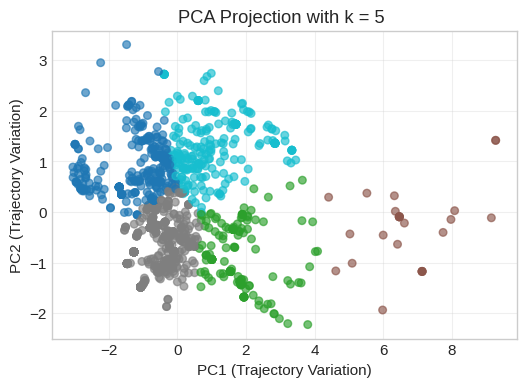

In [38]:


plt.figure(figsize=(6, 4))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters_5,
    cmap="tab10",
    alpha=0.65,
    s=30
)

plt.xlabel("PC1 (Trajectory Variation)")
plt.ylabel("PC2 (Trajectory Variation)")
plt.title("PCA Projection with k = 5 ")
plt.grid(True, alpha=0.3)
plt.show()


In [25]:
cluster_summary = (
    trajectory_features
    .groupby("cluster")[["mean_cost", "volatility", "growth_08_18"]]
    .mean()
    .round(3)
)

cluster_summary


,mean_cost,volatility,growth_08_18
cluster,,,
0,119.732,10.058,0.022
1,122.667,20.034,0.534
2,143.358,50.420,1.307
3,74.489,6.814,0.290


In [27]:
from scipy.cluster.hierarchy import linkage

Z = linkage(X_traj, method="ward")
print("Linkage matrix shape:", Z.shape)


Linkage matrix shape: (1273, 4)


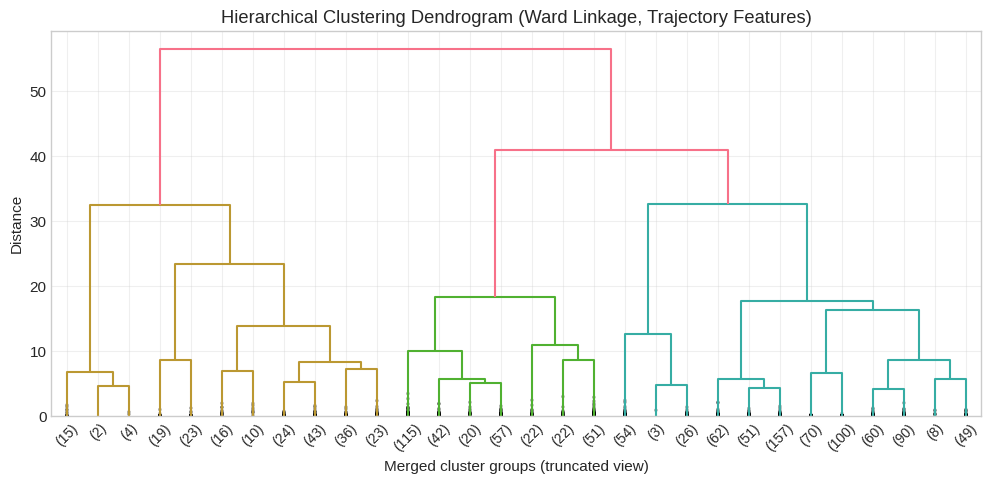

In [28]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=45,
    leaf_font_size=10,
    show_contracted=True
)
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage, Trajectory Features)")
plt.xlabel("Merged cluster groups (truncated view)")
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.show()


The dendrogram visualizes the hierarchical similarity structure among counties based on long-run childcare cost trajectory features. Because plotting all individual counties produces an unreadable figure, I used a truncated dendrogram that shows only the final merges. This helps identify whether there are any break points where the distance between merges increases sharply, which suggests plausible cluster counts.

In [29]:
from scipy.cluster.hierarchy import fcluster

hier_cluster = fcluster(Z, t=4, criterion="maxclust")
trajectory_features["hier_cluster"] = hier_cluster

print("Hierarchical cluster counts (k=4):")
print(trajectory_features["hier_cluster"].value_counts().sort_index())


Hierarchical cluster counts (k=4):
hier_cluster
1    215
2    329
3     83
4    647
Name: count, dtype: int64


To directly compare hierarchical clustering with my K-Means segmentation, I cut the dendrogram into 4 clusters (matching the K-Means choice). This is to check whether hierarchical clustering yields a similarly interpretable structure or produces extreme imbalance.

In [30]:
comparison = pd.crosstab(
    trajectory_features["cluster"],
    trajectory_features["hier_cluster"],
    rownames=["KMeans_cluster"],
    colnames=["Hier_cluster"]
)

comparison


Hier_cluster,1,2,3,4
KMeans_cluster,,,,
0,6,224,83,84
1,176,99,0,0
2,26,0,0,0
3,7,6,0,563


When comparing K-Means and hierarchical clustering, we see strong alignment between the two methods. Most counties assigned to a given K-Means cluster are concentrated within one or two hierarchical clusters, and in some cases map almost one-to-one. This consistency suggests that the identified trajectory patterns are not artifacts of a specific clustering algorithm but reflect stable underlying structure in the data.

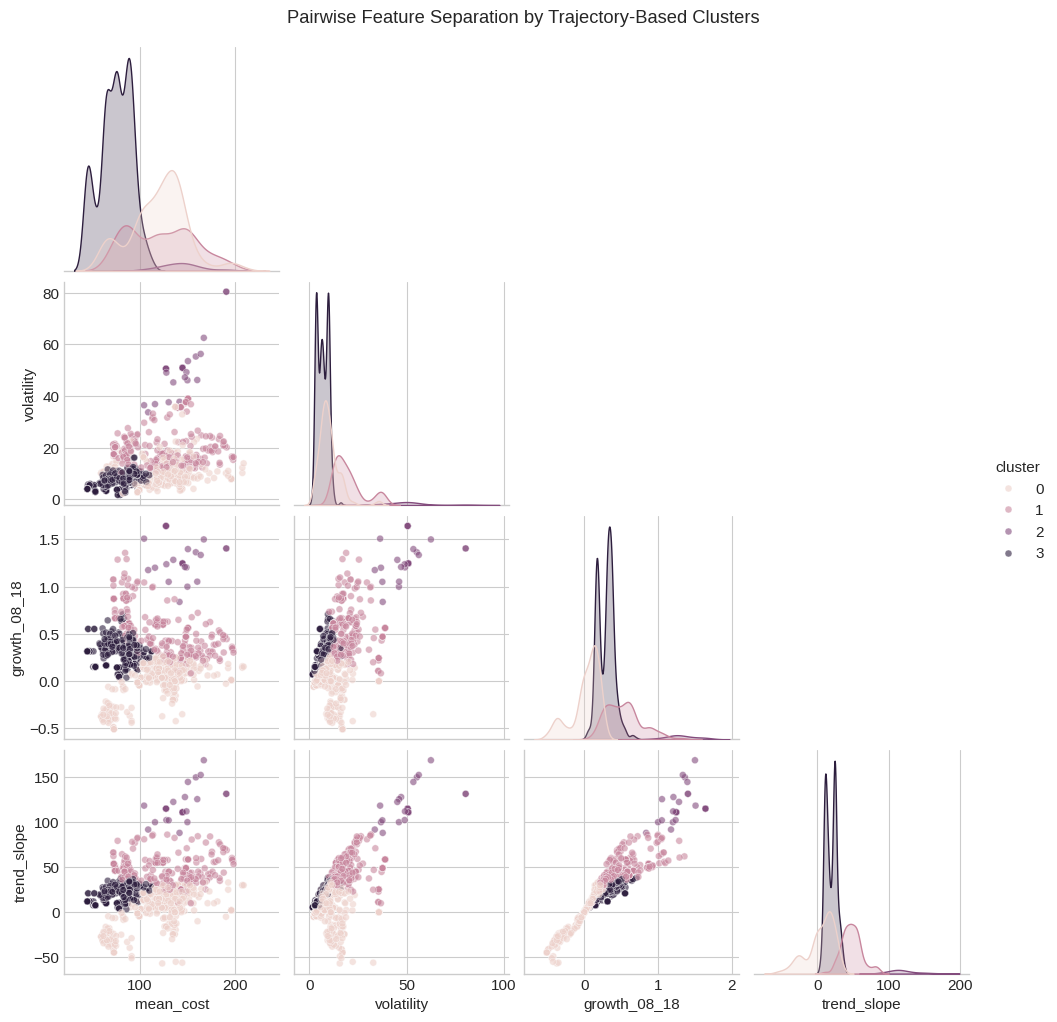

In [26]:
sns.pairplot(
    trajectory_features,
    vars=["mean_cost", "volatility", "growth_08_18", "trend_slope"],
    hue="cluster",
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.6, "s": 25}
)

plt.suptitle(
    "Pairwise Feature Separation by Trajectory-Based Clusters",
    y=1.02
)
plt.show()


The pair plot illustrates how counties separate across multiple childcare cost trajectory dimensions once clustered. Distinct clusters emerge along volatility and long-run growth axes, with high-cost counties exhibiting both greater volatility and stronger upward trends. While some overlap remains, clusters occupy systematically different regions of the feature space, confirming that childcare cost trajectories are heterogeneous and cannot be characterized by a single average pattern.

## 11. Conclusion



This analysis set out to determine whether U.S. counties could be meaningfully segmented based on childcare cost dynamics over time. An initial recession-focused approach (2008–2012) showed that most counties experienced relatively small and similar changes during the recession and recovery period. Clustering on these short-run features produced highly imbalanced groups, indicating that recession behavior alone was not sufficient to distinguish persistent differences across counties.

Shifting the focus to long-run cost trajectories (2008–2018) provided clearer structure. By summarizing each county’s trajectory using features capturing average cost level, overall growth, volatility, and trend slope, I was able to identify distinct and interpretable patterns. K-Means clustering with k = 4 produced balanced segments that were visually separable in PCA space, with the first two principal components explaining approximately 89% of the total variance. Hierarchical clustering using Ward’s method yielded a similar partition, reinforcing the robustness of the segmentation.

Overall, the results suggest that counties are differentiated less by short-term recession responses and more by persistent, long-term childcare cost trajectories. These trajectory-based segments provide a more stable and interpretable framework for understanding structural differences across counties, making them more useful for policy analysis and strategic decision-making than recession-only classifications.


##  Generative AI Usage Disclosure
Generative AI (ChatGPT) was used as a support tool throughout this project primarily for conceptual clarification, technical troubleshooting, and writing refinement. Specifically, it was used to clarify statistical concepts (e.g., dimensionality reduction and PCA interpretation), to assist with Python visualization syntax, and to help refine written explanations for clarity.


